# Learned Tuner Evaluation

In [1]:
from copy import deepcopy
import os
import pathlib
import sys

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
from matplotlib.ticker import PercentFormatter
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats as stats

In [3]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

In [4]:
sys.path.append('../..')

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.solver import QLSMSolver, ClassicSolver
from endure.lsm.types import Policy, System, LSMDesign, LSMBounds
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [5]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

# Loading Model

In [74]:
path = '/scratchNVMe/ndhuynh/other_data/models/ltune/klsm_100824_1324/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
# config = Reader.read_config('../../endure.toml')
cf = EndureCost(config)
design_type = getattr(Policy, config["lsm"]["design"])
bounds = LSMBounds(**config["lsm"]["bounds"])
design_type, bounds

(<Policy.KHybrid: 3>,
 LSMBounds(max_considered_levels=20, bits_per_elem_range=(1, 10), size_ratio_range=[2, 31], page_sizes=[4, 8, 16], entry_sizes=[1024, 2048, 4096, 8192], memory_budget_range=[5, 20], selectivity_range=[1e-07, 1e-09], elements_range=[100000000, 1000000000]))

In [84]:
model = LTuneModelBuilder(
    size_ratio_range=bounds.size_ratio_range,
    max_levels=bounds.max_considered_levels,
    **config["ltune"]["model"],
).build_model(design_type)
model_name = os.path.join(path, 'best.model')
model_name = os.path.join(path, 'checkpoints/epoch_10.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

/tmp/ipykernel_3018779/1140831709.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(model_name)


<All keys matched successfully>

In [85]:
torchinfo.summary(model, (1, 9), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
KapLSMTuner                              [1, 610]                  --
├─BatchNorm1d: 1-1                       [1, 9]                    18
├─Linear: 1-2                            [1, 64]                   640
├─ReLU: 1-3                              [1, 64]                   --
├─Dropout: 1-4                           [1, 64]                   --
├─Sequential: 1-5                        [1, 64]                   --
│    └─Linear: 2-1                       [1, 64]                   4,160
│    └─Linear: 2-2                       [1, 64]                   4,160
│    └─Linear: 2-3                       [1, 64]                   4,160
├─Linear: 1-6                            [1, 64]                   4,160
├─Linear: 1-7                            [1, 1]                    65
├─Linear: 1-8                            [1, 64]                   4,160
├─Linear: 1-9                            [1, 29]                   1,

# Util Module    

In [86]:
ltune_util = LTuneEvalUtil(config, model, design_type)

/home/ndhuynh/repo/endurance/notebook/experiments/../../endure/ltune/loss.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(


In [87]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)
# design, system

# Training Loss

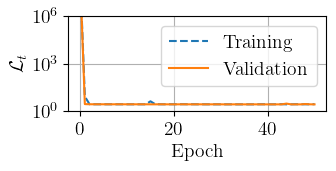

In [88]:
# path = '/scratchNVMe/ndhuynh/other_data/models/ltune/klsm_100924_1023/'
losses = pd.read_csv(os.path.join(path, 'losses.csv'))
losses = losses.loc[:]

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(width, 0.6*height))
ax.plot(losses['epoch'], losses['train_loss'], '--', label='Training')
ax.plot(losses['epoch'], losses['test_loss'], '-', label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'$\mathcal{L}_t$')
ax.set_yscale('log')
ax.set_yticks([1e6, 1e3, 1e0])
ax.set_ylim([1e0, 1e6])
ax.grid()
_ = ax.legend()
# save_fig(fig, 'ltune_loss.pdf')

In [89]:
losses.idxmin()

epoch          0
train_loss    34
test_loss     39
dtype: int64

# Evaluation

Generate our table samples with a fixed random seed

In [90]:
np.random.seed(2169)
num_samples = 5000
table = []
solver_nominal_kwargs = {'init_args': np.array([3, 3, 1])} # (h, T, K)
for _ in tqdm(range(num_samples)):
    row = ltune_util.gen_sample_eval(solver_nominal_kwargs=solver_nominal_kwargs)
    table.append(row)

table = pd.DataFrame(table)

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/ndhuynh/miniconda3/envs/axe/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [91]:
table['delta_cost'] = (table['stune_cost'] - table['ltune_cost']) / table['stune_cost']
table['delta_loss'] = (table['stune_loss'] - table['ltune_loss']) / table['stune_loss']
table['stune_diff'] = (table['stune_cost'] - table['stune_loss']) / table['stune_cost']
table['ltune_diff'] = (table['ltune_cost'] - table['ltune_loss']) / table['ltune_cost']
table['ltune_mbuff'] = ((table['H'] - table['ltune_h']) * table['N']) / (1 * 1024 * 1024 * 1024 * 8)

wl_cols = ['z0', 'z1', 'q', 'w', 'H', 'N']
stune_cols = ['stune_h', 'stune_T', 'stune_level']
ltune_cols = ['ltune_h', 'ltune_T', 'ltune_level']
cost_cols = ['stune_cost', 'stune_loss', 'ltune_cost', 'ltune_loss'] #, 'ltune_loss_direct']
delta_cols = ['delta_cost', 'delta_loss']
cols = wl_cols + stune_cols + ltune_cols + cost_cols + delta_cols
table.sort_values(by='delta_cost', ascending=True).head(20)[cols]

,z0,z1,q,w,H,N,stune_h,stune_T,stune_level,ltune_h,ltune_T,ltune_level,stune_cost,stune_loss,ltune_cost,ltune_loss,delta_cost,delta_loss
2190,0.564,0.008,0.000,0.428,18.682101,929397293,15.808858,7,4.0,9.794242,11,2.0,0.043779,0.198282,0.086795,0.040649,-0.982597,0.794994
4800,0.097,0.035,0.002,0.866,15.708503,954274751,6.534365,21,3.0,2.657202,11,3.0,0.572276,1.640233,1.066830,1.150508,-0.864186,0.298570
4759,0.231,0.018,0.003,0.748,15.885380,642072991,9.963564,21,3.0,3.505903,11,3.0,1.083133,1.959327,1.967933,1.847738,-0.816890,0.056953
651,0.351,0.045,0.002,0.602,19.309827,909597173,10.197504,29,3.0,5.394627,11,3.0,0.507451,1.377487,0.882232,0.916228,-0.738557,0.334855
4769,0.041,0.251,0.004,0.704,12.253097,489321463,7.977583,23,3.0,3.272652,11,3.0,1.405892,2.612617,2.108249,2.210200,-0.499581,0.154028
3255,0.321,0.149,0.002,0.528,17.659952,612359648,12.246484,11,4.0,6.126181,14,3.0,0.423891,0.498527,0.626857,0.550062,-0.478817,-0.103374
2310,0.216,0.033,0.009,0.742,8.219386,757036975,5.211269,13,4.0,1.938120,14,3.0,1.135273,1.559635,1.660049,1.683907,-0.462246,-0.079680
1537,0.526,0.007,0.001,0.466,13.925465,266347673,11.613355,9,4.0,8.129781,11,3.0,0.088072,0.211445,0.127798,0.100260,-0.451060,0.525835
2055,0.259,0.005,0.012,0.724,8.423840,484530336,6.129203,12,4.0,2.228410,11,3.0,1.068400,1.278650,1.492930,1.534185,-0.397351,-0.199847
4525,0.405,0.024,0.001,0.570,11.684659,662337366,10.434904,11,4.0,7.156847,11,3.0,0.123853,0.224369,0.170866,0.150971,-0.379593,0.327134


## Checking decision distribution of size ratio

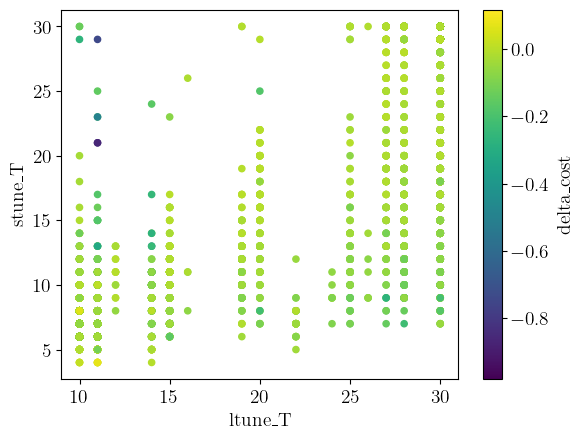

In [92]:
ax = table.plot.scatter(x='ltune_T', y='stune_T', c='delta_cost')

## Analytical Cost Model

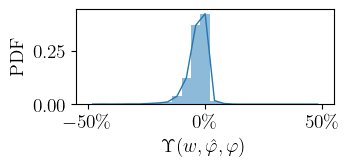

In [16]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(width, 0.6*height))

data = table['delta_cost']
hist, bins, _ = ax.hist(data, bins=25, weights=np.ones_like(data)/len(data), alpha=0.5, density=False, color='tab:blue', range=(-0.5, 0.5))
# hist, _, _ = ax.hist(data, bins=20, alpha=1, density=True, color='tab:blue', range=(-0.5, 0.5))
bin_center = (bins[1:] + bins[:-1]) / 2
ax.plot(bin_center, hist, linewidth=1)

ax.set_ylabel('PDF')
ax.set_xlabel(r'$\Upsilon(w, \hat{\varphi}, \varphi)$')
# ax.vlines(x=0, ymin=0, ymax=hist.max()+0.05, color='black', linestyles='dashed', linewidth=0.8)
# ax.set_xlim([-0.5, 0.5])
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.show()
# save_fig(fig, 'ltuner_performance.pdf')

Performance values within 10% performance band

In [17]:
len(table[table.delta_cost > -0.1]) / len(table)

0.9386

Positive Performance Values

In [18]:
len(table[table.delta_cost > 0]) / len(table)

0.0868

In [19]:
len(table[table.delta_cost < -1]) / len(table)

0.0

## Learned Cost Model

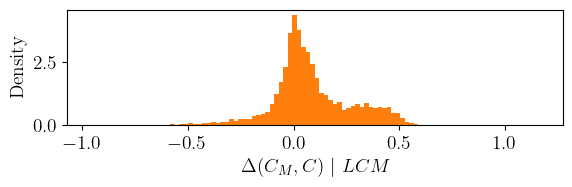

In [20]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6.4, 1.5))

data = table['delta_loss']
# hist, _, _ = ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), density=False, color='tab:orange')
hist, _, _ = ax.hist(data, bins=100, density=True, color='tab:orange')

ax.set_ylabel('Density')
ax.set_xlabel(r' \( \Delta(C_M, C)\ |\ LCM \)')
plt.show()
# save_fig(fig, 'ltuner_performance_lcm.pdf')

## Workload Correlations

In [21]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads', labelpad=-30)
    ax.set_ylabel('Range-Reads', labelpad=-30)
    ax.set_zlabel('Writes', labelpad=-30)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis', rasterized=True)
    cbar = plt.colorbar(sc, pad=0.05, shrink=0.6)
    cbar.set_label(trend)
    # cbar.ax.tick_params(labelsize=12)
    # font = {'size': 12}
    # ax.tick_params('x', labelsize=font['size'])
    # ax.tick_params('y', labelsize=font['size'])
    # ax.tick_params('z', labelsize=font['size'])
    
    return fig, ax, sc, cbar

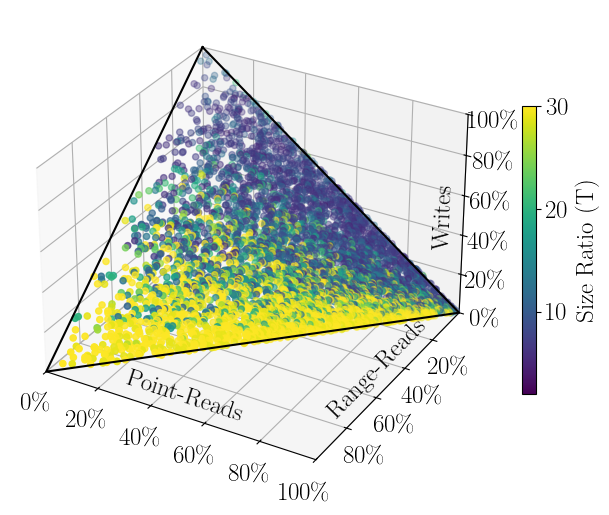

In [22]:
plt.rcParams.update({'font.size': 18})
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_T')
cbar.set_label('Size Ratio (T)')
sc.set_clim([2, 30])
plt.show()
# save_fig(fig, 'analytical_tuner_size_ratio.pdf')

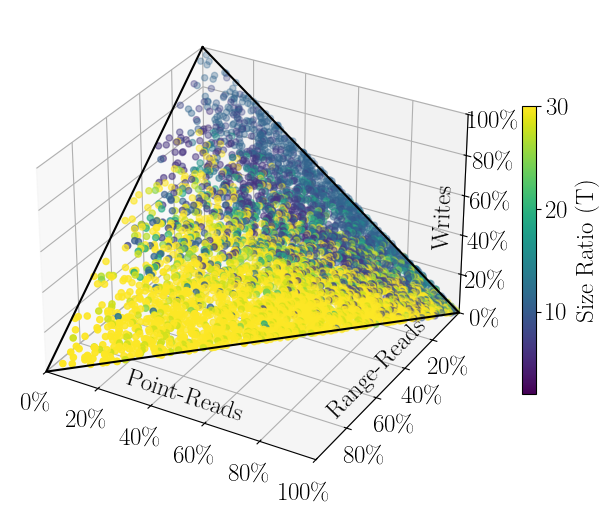

In [23]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_T')
cbar.set_label('Size Ratio (T)')
# plt.suptitle('AXE: Learned Tuner', x=0.4)
sc.set_clim([2, 30])
plt.show()
# save_fig(fig, 'learned_tuner_size_ratio.pdf')

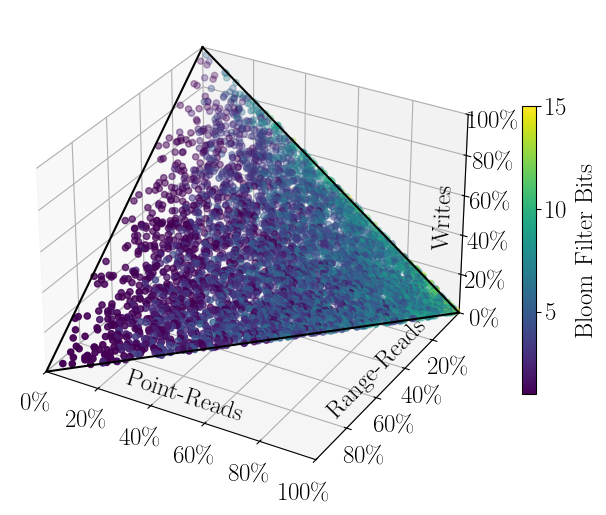

In [24]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_h')
cbar.set_label('Bloom Filter Bits')
sc.set_clim([1, 15])
plt.show()
# save_fig(fig, 'analytical_tuner_bf.pdf')

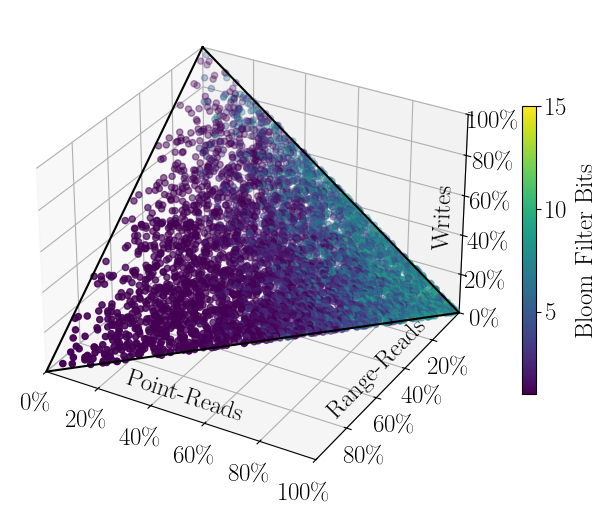

In [25]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_h')
cbar.set_label('Bloom Filter Bits')
sc.set_clim([1, 15])
plt.show()
# save_fig(fig, 'learned_tuner_bf.pdf')

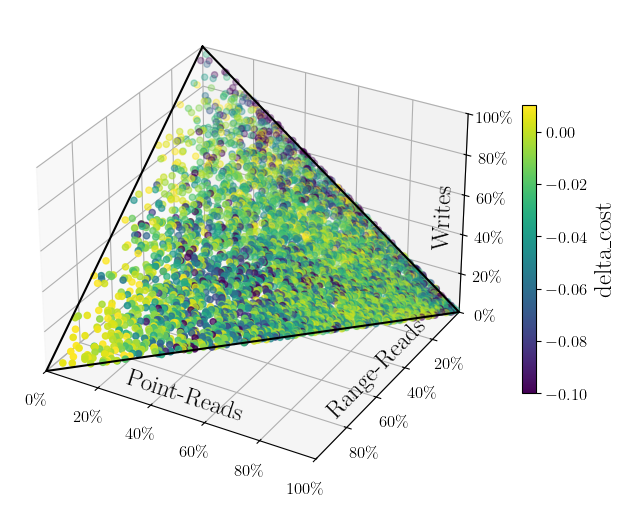

In [26]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads', labelpad=-30)
ax.set_ylabel('Range-Reads', labelpad=-30)
ax.set_zlabel('Writes', labelpad=-30)

sc = ax.scatter(table['z0'] + table['z1'], table['q'], table['w'], c=table['delta_cost'], cmap='viridis', rasterized=True, vmin=-0.1, vmax=0.01)
cbar = plt.colorbar(sc, pad=0.05, shrink=0.6)
cbar.set_label('delta_cost')
cbar.ax.tick_params(labelsize=12)
font = {'size': 12}
ax.tick_params('x', labelsize=font['size'])
ax.tick_params('y', labelsize=font['size'])
ax.tick_params('z', labelsize=font['size'])

<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:19: SyntaxWarning: invalid escape sequence '\g'
<>:19: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:19: SyntaxWarning: invalid escape sequence '\g'
<>:19: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_3018779/248343027.py:18: SyntaxWarning: invalid escape sequence '\%'
  ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label=f'Great $(< {cutoff*100:.0f}\%)$', alpha=0.3, marker='+', color='tab:blue', rasterized=True)
/tmp/ipykernel_3018779/248343027.py:19: SyntaxWarning: invalid escape sequence '\g'
  ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label=f'Poor $(\ge {cutoff*100:.0f}\%)$', alpha=1, marker='.', color='black', rasterized=True, s=10)
/tmp/ipykernel_3018779/248343027.py:19: SyntaxWarning: invalid escape sequence '\%'
  ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label=f'Poor $(\ge {cutoff*100:.0f}\%)

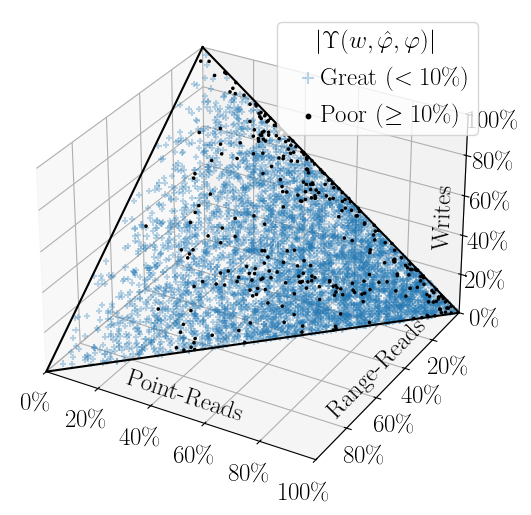

In [27]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads', labelpad=-30)
ax.set_ylabel('Range-Reads', labelpad=-30)
ax.set_zlabel('Writes', labelpad=-30)

cutoff = (0.1)
groupa = table[(table['delta_cost'] > -cutoff)]
groupb = table[(table['delta_cost'] < -cutoff)]
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label=f'Great $(< {cutoff*100:.0f}\%)$', alpha=0.3, marker='+', color='tab:blue', rasterized=True)
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label=f'Poor $(\ge {cutoff*100:.0f}\%)$', alpha=1, marker='.', color='black', rasterized=True, s=10)
ax.legend(loc='upper right', markerscale=2, title=r'$|\Upsilon(w, \hat{\varphi}, \varphi)|$', handletextpad=-0.5, borderpad=0.25)
plt.show()
# save_fig(fig, 'ltuner_performance_cutoff.pdf')

In [28]:
def gen_table_with_init(num_samples=5000, solver_nominal_kwargs = {'init_args': np.array([3, 3, 1])}):
    np.random.seed(2169)
    num_samples = 5000
    table = []
    for _ in tqdm(range(num_samples)):
        row = ltune_util.gen_sample_eval(solver_nominal_kwargs=solver_nominal_kwargs)
        table.append(row)
    
    table = pd.DataFrame(table)
    table['delta_cost'] = (table['stune_cost'] - table['ltune_cost']) / table['stune_cost']
    table['delta_loss'] = (table['stune_loss'] - table['ltune_loss']) / table['stune_loss']
    table['stune_diff'] = (table['stune_cost'] - table['stune_loss']) / table['stune_cost']
    table['ltune_diff'] = (table['ltune_cost'] - table['ltune_loss']) / table['ltune_cost']
    table['ltune_mbuff'] = ((table['H'] - table['ltune_h']) * table['N']) / (1 * 1024 * 1024 * 1024 * 8)

    return table

In [29]:
best_table = gen_table_with_init()
decent_table = gen_table_with_init(solver_nominal_kwargs={'init_args': np.array([5, 10, 9])})
bad_table = gen_table_with_init(solver_nominal_kwargs={'init_args': np.array([10, 30, 29])})

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/ndhuynh/miniconda3/envs/axe/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/ndhuynh/miniconda3/envs/axe/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [30]:
bad_table['stune_cost']

0       1.530357
1       1.263464
2       3.874059
3       2.133872
4       3.803779
          ...   
4995    3.392535
4996    1.258479
4997    5.382994
4998    0.251949
4999    1.779200
Name: stune_cost, Length: 5000, dtype: float64

In [31]:
bad_table['stune_cost'].loc[2], best_table['stune_cost'].loc[2]

(3.874059148127157, 2.1555965737662075)

In [32]:
normed_data = {}
for label, table in (('Boundary', bad_table), ('Random', decent_table)):
    normed_data[label] = (best_table['stune_cost'] - table['stune_cost']) /  best_table['stune_cost']

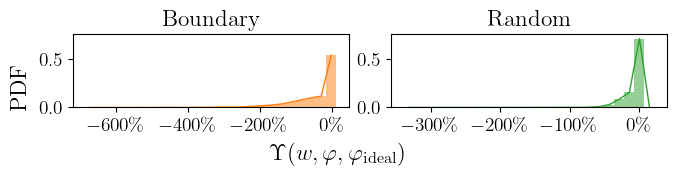

In [33]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(2*width, 0.8*height), constrained_layout=True)
colors = ('tab:orange', 'tab:green')
labels = ('Boundary', 'Random')

for idx, ((label, data), ax) in enumerate(zip(normed_data.items(), axes)):
    weights = np.ones_like(data)/len(data)
    hist, bins, _ = ax.hist(data, alpha=0.5, bins=25, weights=weights, density=False, color=colors[idx])
    bin_center = (bins[1:] + bins[:-1]) / 2
    ax.plot(bin_center, hist, linewidth=1, color=colors[idx])
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title(labels[idx])
    ax.set_ylim([0, .75])

fig.supylabel('PDF')
fig.supxlabel(r'$\Upsilon(w, \varphi, \varphi_{\text{ideal}})$')
plt.show()
# save_fig(fig, 'black_box_tuner_init.pdf')

In [34]:
import seaborn as sns

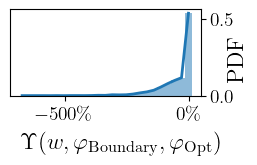

In [35]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(0.7*width, 0.75*height), constrained_layout=True)

data = normed_data['Boundary']
weights = np.ones_like(data)/len(data)
hist, bins, _ = ax.hist(data, alpha=0.5, bins=25, weights=weights, density=False, color='tab:blue')
bin_center = (bins[1:] + bins[:-1]) / 2
ax.plot(bin_center, hist, linewidth=2, color='tab:blue')
ax.yaxis.tick_right()
ax.xaxis.set_major_formatter(PercentFormatter(1))
# ax.set_ylim([0, .75])

fig.supylabel('PDF', x=0.95, y=0.65)
fig.supxlabel(r'$\Upsilon(w, \varphi_{\text{Boundary}}, \varphi_{\text{Opt}})$')
plt.show()
save_fig(fig, 'boundary_hist.pdf')

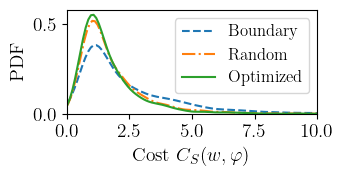

In [36]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(1*width, 0.8*height), constrained_layout=True)
sns.kdeplot(bad_table['stune_cost'],    ax=ax, label='Boundary', linestyle='--')
sns.kdeplot(decent_table['stune_cost'], ax=ax, label='Random', linestyle='dashdot')
sns.kdeplot(best_table['stune_cost'],   ax=ax, label='Optimized')
ax.legend(fontsize=12)
# ax.set_xscale('log')
ax.set_xlim([0, 10])
# ax.set_yticks([0, 0.5, 1])
# ax.set_ylim([0, 1])
ax.set_xlabel(r'Cost $C_S(w, \varphi)$')
ax.set_ylabel('PDF')
plt.show()

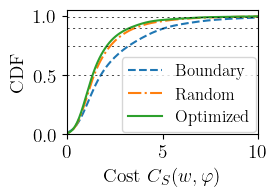

In [37]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(0.8*width, 0.9*height), constrained_layout=True)
sns.kdeplot(bad_table['stune_cost'],    cumulative=True, ax=ax, label='Boundary', linestyle='--')
sns.kdeplot(decent_table['stune_cost'], cumulative=True, ax=ax, label='Random', linestyle='dashdot')
sns.kdeplot(best_table['stune_cost'],   cumulative=True, ax=ax, label='Optimized')
ax.hlines(y=0.50, xmin=0, xmax=10, color='black', linewidth=0.5, linestyle=(0, (3, 5)))
ax.hlines(y=0.75, xmin=0, xmax=10, color='black', linewidth=0.5, linestyle=(0, (3, 5)))
ax.hlines(y=0.90, xmin=0, xmax=10, color='black', linewidth=0.5, linestyle=(0, (3, 5)))
ax.hlines(y=0.99, xmin=0, xmax=10, color='black', linewidth=0.5, linestyle=(0, (3, 5)))
ax.legend(fontsize=12, bbox_to_anchor=(1.03, -0.05), loc='lower right')
# ax.set_xscale('log')
ax.set_xlim([0, 10])
# ax.set_yticks([0, 0.5, 1])
# ax.set_ylim([0, 1])
ax.set_xlabel(r'Cost $C_S(w, \varphi)$')
ax.set_ylabel('CDF')
save_fig(fig, 'black_box_tuner_init.pdf')
plt.show()

In [38]:
bad_table['stune_cost'] / best_table['stune_cost']

0       1.000000
1       1.255679
2       1.797210
3       1.000000
4       1.000000
          ...   
4995    1.142818
4996    0.999998
4997    1.644181
4998    1.083538
4999    1.000000
Name: stune_cost, Length: 5000, dtype: float64

In [39]:
best_table['stune_cost'].loc[1]

1.0061999647161126

In [40]:
bad_table['stune_cost'].loc[1]

1.2634640139485407

In [41]:
pv_bound = np.percentile(bad_table['stune_cost'] / best_table['stune_cost'], [25, 50, 75, 90, 99, 99.9])
pv_rand = np.percentile(decent_table['stune_cost'] / best_table['stune_cost'], [25, 50, 75, 90, 99, 99.9])
pv_bound, pv_rand

(array([1.        , 1.08320524, 1.70857874, 2.35927286, 4.14124002,
        6.21040105]),
 array([0.99999995, 1.00008374, 1.09712211, 1.24996214, 1.67707014,
        3.31205854]))

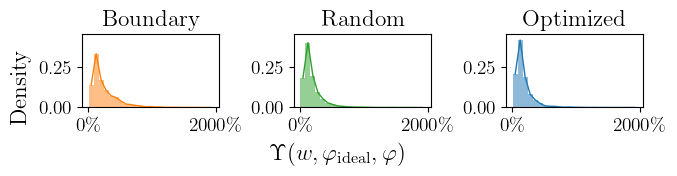

In [42]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(2*width, 0.8*height), constrained_layout=True)
colors = ('tab:orange', 'tab:green', 'tab:blue')
labels = ('Boundary', 'Random', 'Optimized',)

for idx, (d, ax) in enumerate(zip((bad_table, decent_table, best_table), axes)):
    data = d['stune_cost']
    weights = np.ones_like(data)/len(data)
    # hist, bins, _ = ax.hist(data, alpha=0.5, bins=25, weights=weights, density=False, color=colors[idx], range=(-.5, 1))
    hist, bins, _ = ax.hist(data, alpha=0.5, bins=25, weights=weights, density=False, color=colors[idx])
    # bins = 10 ** np.linspace(np.log10(data.min()), np.log10(data.max()))
    # bins = 25
    # hist, bins, _ = ax.hist(data, alpha=0.5, bins=bins, density=True, color=colors[idx])
    bin_center = (bins[1:] + bins[:-1]) / 2
    ax.plot(bin_center, hist, linewidth=1, color=colors[idx])
    ax.set_title(labels[idx])
    ax.set_ylim([0, .45])
    # ax.set_xscale('log')
    ax.xaxis.set_major_formatter(PercentFormatter(1))

fig.supylabel('Density')
fig.supxlabel(r'$\Upsilon(w, \varphi_{\text{ideal}}, \varphi)$')
plt.show()
# save_fig(fig, 'black_box_tuner_init.pdf')

In [43]:
import sqlite3

connection = sqlite3.connect("../../fixed_sys_wl.db")
fixed_env_table = pd.read_sql("SELECT * FROM environments;", connection, index_col="env_id")
fixed_run_table = pd.read_sql("SELECT * FROM tunings;", connection, index_col="idx")

hist_data = np.array((
    bad_table.iloc[8].stune_cost,
    best_table.iloc[8].stune_cost,
    fixed_run_table.groupby(['round']).cost.mean().loc[10],
    fixed_run_table.groupby(['round']).cost.mean().min(),
    best_table.iloc[8].ltune_cost
))
regret_data = np.array((
    fixed_run_table.groupby(['round']).cost.mean().cumsum().loc[10],
    fixed_run_table.groupby(['round']).cost.mean().cumsum().loc[99],
    best_table.iloc[8].ltune_cost,
))
x = np.array(range(len(hist_data)))

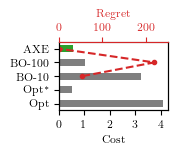

In [44]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(0.5*width, 0.7*height), constrained_layout=True)
y_pos = np.array(range(len(hist_data)))

ax2 = ax.twiny()
ax.barh(y_pos, hist_data, color=['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:green'], height=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(['Opt', 'Opt$^*$', 'BO-10', 'BO-100', 'AXE'])
ax.set_xlabel('Cost')
ax.set_xticks([0, 1, 2, 3, 4])

ax2.plot(regret_data, np.array((2, 3, 4)), linestyle='--', marker='.', color='tab:red')
ax2.set_xlabel('Regret', color='tab:red')
ax2.spines['top'].set_color('tab:red')
ax2.set_xticks([0, 100, 200])
ax2.tick_params(axis='x', colors='tab:red')
ax2.set_xlim([0, 250])

plt.show()

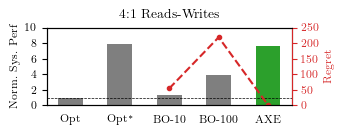

In [45]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(1*width, 0.6*height), constrained_layout=True)
y_data = 1 / hist_data
y_data = y_data / y_data[0]

ax2 = ax.twinx()
ax.bar(x, y_data, color=['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:green'], width=0.5)
ax.set_ylabel('Norm. Sys. Perf')
ax.set_xticks(x)
ax.set_xticklabels(['Opt', 'Opt$^*$', 'BO-10', 'BO-100', 'AXE'])
ax.xaxis.set_ticks_position('none') 
ax.tick_params(axis="x") 
ax.set_ylim([0, 10])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.axhline(y=1, color='black', linestyle='--', linewidth=0.5)

ax2.plot(np.array((2, 3, 4)), regret_data, linestyle='--', marker='.', color='tab:red')
ax2.set_ylabel('Regret', color='tab:red')
ax2.spines['right'].set_color('tab:red')
ax2.tick_params(axis='y', colors='tab:red')
ax2.set_ylim([0, 250])
ax2.set_yticks([0, 50, 100, 150, 200, 250])

ax.set_title(r'4:1 Reads-Writes')

plt.show()
# save_fig(fig, 'intro_bar.pdf')

In [46]:
# plt.rcParams.update({'font.size': 8})
# fig, ax = plt.subplots(figsize=(1*width, 0.6*height), constrained_layout=True)

# ax2 = ax.twinx()
# ax.bar(x + 0.5, hist_data, color=['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:green'])
# ax.set_ylabel('Cost (Lower is Better)')
# ax.set_xticks(x)
# ax.set_xticklabels(['Optimizer', 'Optimizer$^*$', '10it BO', '100it BO', 'AXE'])
# ax.xaxis.set_ticks_position('none') 
# ax.tick_params(axis="x", rotation=20) 

# ax2.plot(np.array((2, 3, 4)) + 0.5, regret_data, linestyle='--', marker='o', color='tab:red')
# ax2.set_ylabel('Regret', color='tab:red')
# ax2.spines['right'].set_color('tab:red')
# ax2.tick_params(axis='y', colors='tab:red')
# ax2.set_ylim([-20, 250])

# ax.set_title(r'Workload - 4:1 Reads-Writes')

# plt.show()
# save_fig(fig, 'intro_bar.pdf')

In [47]:
hist_data

array([4.08036112, 0.51916439, 3.21416041, 1.03709007, 0.53919498])

In [48]:
best_table.loc[8]

z0                                                               0.712
z1                                                               0.053
q                                                                0.037
w                                                                0.198
B                                                                 32.0
s                                                                  0.0
E                                                                 1024
H                                                             5.131612
N                                                            305003053
stune_policy                                                         3
stune_h                                                       4.389554
stune_T                                                             11
stune_level                                                        4.0
stune_cost                                                    0.519164
stune_

In [49]:
best_table.loc[8][['z0', 'z1', 'q', 'w', 'B', 's', 'E', 'H', 'N']].to_dict()

{'z0': 0.712,
 'z1': 0.05300000000000005,
 'q': 0.03700000000000003,
 'w': 0.19799999999999995,
 'B': 32.0,
 's': 7.886971674616463e-08,
 'E': 1024,
 'H': 5.13161187116606,
 'N': 305003053}